# Introduction

This project will examine trends across real like stock market data. The analysis will be done looking at 12 companies spreading across 4 industries.  
The data used is from the ``yfinance`` module within Python.  

The key areas that will be assessed include industry and company trenads, volatility and correlation.  

Questions that we will base the analysis hopes to answer: 
- What industries performed best over a certain time period?  
- Are there trends in stock price movements by quarter, year, decade?  
- Can we predict stock price trends using historical data?  
- Impact of certain events on the stock prices i.e. US election, end of quarter performance announcements by companies, press releases etc.



## Description of fields looked at in the project

| **Column Name**    | **Description**                                                                 | **Unit**        | **Relevance to Analysis**                                                                                   |
|--------------------|---------------------------------------------------------------------------------|----------------|--------------------------------------------------------------------------------------------------------------|
| **Date (Index)**   | The trading date for the stock. Stored as a **DatetimeIndex**.                   | YYYY-MM-DD HH:MM:SS| Used for **time-series analysis**, rolling calculations, and **trend identification**.                       |
| **Open**           | The **price** of the stock when the market opened on for the trading day.   | USD ($)        | Provides insight into **market sentiment** at the start of each trading day.                                |
| **High**           | The **highest price** reached by the stock during the trading day.               | USD ($)        | Useful for identifying **intraday volatility** and **price fluctuations**.                                  |
| **Low**            | The **lowest price** reached by the stock during the trading day.                | USD ($)        | Complements the **High** value to assess **volatility**.                                                     |
| **Close**          | The **price** of the stock when the market closes on for the trading day. | USD ($)        | Primary metric for **trend analysis**, **returns**, and **correlation studies**.                             |
| **Volume**         | The **number of shares** traded during the day.                                  | Shares         | Measures **market activity**, **liquidity**, and **investor interest**.                                      |
| **Dividends**      | Cash payments made by companies to shareholders per share.                       | USD ($)        | Indicates **profit-sharing** practices and **stability**. |
| **Industry**       | The **sector classification** for the stock (e.g., Technology, Renewable Energy).| Text           | Allows for **grouped comparisons** between industries in performance and correlations.                        |
| **Company**        | The **ticker symbol** representing a specific company.                           | Text           | Enables **company-level filtering** and analysis.                                                            |
| **Timeframe**      | The **data range** selected for analysis (1y, 5y, 10y, etc.).                     | Text           | Provides **context** for comparisons between short-, mid-, and long-term performance.                        |
| **Volatility**     | The **percentage change** between the day’s high and low prices.                  | % (percent)    | Measures **risk** and **price fluctuations** for both **individual stocks** and **industries**.               |
| **Daily_Returns**  | The **percentage change** in close price from the previous day.                   | % (percent)    | Evaluates **performance trends**, **correlations**, and **momentum shifts**.                                 |

# Analysis

### Project set-up

In [1]:
# importing libraries

import pandas as pd
import yfinance as yf
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# creating a dictionary to define the industries and the companies that will be used for the project
industries = {
    'Technology': ['AAPL', 'MSFT', 'NVDA'], 
    'Quantum Computing': ['IONQ', 'RGTI', 'QBTS'],
    'Electric Vehicles': ['TSLA', 'RIVN', 'LCID'],
    'Renewable Energy': ['NEE', 'FSLR', 'ENPH']
}

In [3]:
# creating a dictionary to store dataFrames to for different time period
industry_dataframes = {
    '5y': pd.DataFrame(),  # mid-term trends (5 years)
    '1y': pd.DataFrame(),  # quarterly/yearly movements (1 year)
    'event_specific': pd.DataFrame(),  # specific date ranges for event analysis 2024 US election
    '10y': pd.DataFrame()  # long-term trends (10 years or max)
}

### Data Collection and Preparation

Due to the newness of some of the industries being considered for the project.  
The timeframe the data is available for each of the choosen companies will be checked to see if they have data available for the last 5 years. 

In [4]:
print(f'Company:\tData starts:\tLatest date:\t5yr available?')
print(f'------------------------------------------------------------------')

# checking the start date of the data for the chosen companies
for industry, companies in industries.items():
        for company in companies:
            ticker = yf.Ticker(company)
            hist = ticker.history(period='max')  # fetching the maximum available data
            start_date = hist.index.min().strftime('%Y-%m-%d')  # getting the earliest date available but looking at the min in the index for each company and formating the start date as a string to be shown in so only the date information and not the timestamp are included
            latest_date = hist.index.max().strftime('%Y-%m-%d')
            if pd.to_datetime(start_date) > pd.Timestamp('2019-12-27'):
                five_yr_available = 'No' 
            else: 
                five_yr_available = 'Yes'
            
            print(f"{company}\t\t{start_date}\t{latest_date}\t{five_yr_available}") # printing the company, date the data is available from, latest date information for the data pulled and a yes/no answer of if the data is available for the last 5 years


Company:	Data starts:	Latest date:	5yr available?
------------------------------------------------------------------
AAPL		1980-12-12	2025-01-06	Yes
MSFT		1986-03-13	2025-01-06	Yes
NVDA		1999-01-22	2025-01-06	Yes
IONQ		2021-01-04	2025-01-06	No
RGTI		2021-04-22	2025-01-06	No
QBTS		2020-12-11	2025-01-06	No
TSLA		2010-06-29	2025-01-06	Yes
RIVN		2021-11-10	2025-01-06	No
LCID		2020-09-18	2025-01-06	No
NEE		1973-02-21	2025-01-06	Yes
FSLR		2006-11-17	2025-01-06	Yes
ENPH		2012-03-30	2025-01-06	Yes


From the above we can see that there are several companies which do not have 5 years worth of data available.  
These are companies belowing to Quantum computing & electronic vechile industries, which is not surprising as the technology for these industries are relatively new/young in comparison to some of the historical companies/industries in the stock market.  

With this information the technology and renewable energy industry will be used for mid-long term analysis. 

In [5]:

# fetching and saving the data for multiple time periods to individual dataframes
for time_period in ['5y', '1y', 'event_specific', '10y']:
    temp_data = []  # storing the data temporarily for each time period so it can be added to the dataframe later
    for industry, companies in industries.items():  # fetching the data for each industry by looping through the key value pairs returned from the .items() method
        for company in companies:  # getting the data for each company within the industry specified for the parent for loop
            # fetching the historical data
            # if loop checking the time_period value per iteration and choosing what steps to complete depending on the value 
            if time_period == 'event_specific': # the code will follow this path if the time period matches event_specific
                hist = yf.Ticker(company).history(start='2023-12-26', end='2024-12-26') # getting the info for the date range specified 
            elif time_period in ['5y', '10y'] and industry in ['Quantum Computing', 'Electric Vehicles']: 
                continue  # skipping fetching 5y and 10y data for the Quantum Computing and Electric Vehicles industries as not all companies have sufficient data for this
            else:
                hist = yf.Ticker(company).history(period=time_period)
            # adding headers and defining which data should be entered for those columns
            hist['Industry'] = industry
            hist['Company'] = company
            hist['Timeframe'] = time_period
            temp_data.append(hist) # adding the details gathered to the temp_data list
    # adding all data for the period into a DataFrame
    industry_dataframes[time_period] = pd.concat(temp_data)
    
# print(industry_dataframes['1y'])
# checking which industries the data is present in the dataframes to ensure the if statement has executed successfully
# commented out for now as testing was successful
# counted_industries_1 = industry_dataframes['1y']['Industry'].value_counts()
# print(f'1 year count:\n{counted_industries_1}\n')
# counted_industries_5 = industry_dataframes['5y']['Industry'].value_counts()
# print(f'5 year count:\n{counted_industries_5}\n')
# counted_industries_es = industry_dataframes['event_specific']['Industry'].value_counts()
# print(f'Event specific count:\n{counted_industries_es}\n')
# counted_industries_10 = industry_dataframes['10y']['Industry'].value_counts()
# print(f'10 year count:\n{counted_industries_10}')


### Checking DataFrames for missing data and the data types of the columns


In [6]:
# lopping through each of the dataframes created to see if any data is missing
for time_period in ['5y', '1y', 'event_specific', '10y']: 
    no_of_blanks = industry_dataframes[time_period].isna().sum().sum() # looking for NaN values and getting the total of the sum of missing values for all columns in the df 
    print(f'The {time_period} data contains {no_of_blanks} missing values.') # printing one summary line to state if there is missing values in the dataset
    df_dtypes = industry_dataframes[time_period].dtypes.value_counts()
    print(f'The following data types can be found in the df:\n{df_dtypes}\n')

The 5y data contains 0 missing values.
The following data types can be found in the df:
float64    6
object     3
int64      1
Name: count, dtype: int64

The 1y data contains 0 missing values.
The following data types can be found in the df:
float64    6
object     3
int64      1
Name: count, dtype: int64

The event_specific data contains 0 missing values.
The following data types can be found in the df:
float64    6
object     3
int64      1
Name: count, dtype: int64

The 10y data contains 0 missing values.
The following data types can be found in the df:
float64    6
object     3
int64      1
Name: count, dtype: int64



From the above we can see there are 3 columns of data type ``object``.  
As calculations and comparitive analysis will be performed later in the project, next the 3 columns which are of dtype ``object`` will be checked to ensure these are not numeric columns which have incorrect dtype assigned. This is done as a value assigned as an ``object`` will not be possible to be used for performing numerical operations later. 

In [7]:
# checking which columns are of dtype object
print('The columns of dtype object are:\n')
for time_period in ['5y', '1y', 'event_specific', '10y']: 
    # Find columns with 'object' data type
    object_cols = industry_dataframes[time_period].select_dtypes(include='object').columns.tolist()
    print(f'{time_period.capitalize()} DataFrame:\n{object_cols}\n')


The columns of dtype object are:

5y DataFrame:
['Industry', 'Company', 'Timeframe']

1y DataFrame:
['Industry', 'Company', 'Timeframe']

Event_specific DataFrame:
['Industry', 'Company', 'Timeframe']

10y DataFrame:
['Industry', 'Company', 'Timeframe']



As the 'Industry', 'Company' and 'Timeframe' are not numeric columns and not needed for calculations, the ``object`` dtype should cause no issues.

### Checking the index data
As analysis and comparisons on the data over different time periods will be performed, having the index be of ``Pandas`` ``datetime`` index is preferred.

In [8]:
# checking the index dtype for each dataframe
for time_period in ['5y', '1y', 'event_specific', '10y']:
    index_dtype = industry_dataframes[time_period].index.dtype
    print(f'The index data type for the {time_period} dataframe is: {index_dtype}')

The index data type for the 5y dataframe is: datetime64[ns, America/New_York]
The index data type for the 1y dataframe is: datetime64[ns, America/New_York]
The index data type for the event_specific dataframe is: datetime64[ns, America/New_York]
The index data type for the 10y dataframe is: datetime64[ns, America/New_York]


From the above output it can be seen that the index data is of the datetime64 dtype which is desired. However, additional information is present suggesting the timezone of the data retrieved is America/New York and not UTC.  
To confirm this, one of the index values will be checked as an example to see how the data is showing.

In [9]:
# printing the first value for the index in each df
print(f'The first index value in each index is:')
for time_period in ['5y', '1y', 'event_specific', '10y']:
    print(f'{time_period}: {industry_dataframes[time_period].index[0]}')  # First index


The first index value in each index is:
5y: 2020-01-06 00:00:00-05:00
1y: 2024-01-08 00:00:00-05:00
event_specific: 2023-12-26 00:00:00-05:00
10y: 2015-01-06 00:00:00-05:00


The timestamp ending in ``-05:00`` confirms that the timestamp is matching the ``ns, America/New_York`` timezone.  
As UTC is typically the standard timezone used worldwide the index will be updated to convert from ``America/New_York`` to ``UTC`` to tidy the data.  
This will also be beneficial to avoid any issues with compatibility should the data want to be reused for analysis for further markets further down the line.

In [10]:
# converting to UTC time and removing the timezone information for each df
for time_period in ['5y', '1y', 'event_specific', '10y']:
    industry_dataframes[time_period].index = industry_dataframes[time_period].index.tz_convert('UTC').tz_localize(None) # converting the timestamp from NY time to UTC and removing the information for the offset (+00:00) for better readibility when using the index for plotting 
    print(f'{time_period}: {industry_dataframes[time_period].index[0]}')  # printing the value for the first index of each df to validate that the timezone information is removed


5y: 2020-01-06 05:00:00
1y: 2024-01-08 05:00:00
event_specific: 2023-12-26 05:00:00
10y: 2015-01-06 05:00:00


In [11]:
# saving the dfs to csv files to verify no issues in the data
for time_period, df in industry_dataframes.items():
    df.to_csv(f'{time_period}_data.csv')

### Setting colours to be used per industry in the plots 


In [12]:

# Define a dictionary mapping industries to colors
colours = {
    'Technology': 'royalblue',
    'Quantum Computing': 'orchid',
    'Electric Vehicles': 'green',
    'Renewable Energy': 'orange'
}

colours_comp = {
    'AAPL': 'royalblue',
    'MSFT': 'orchid',
    'NVDA': 'green',
    'IONQ': 'orange',
    'RGTI': 'firebrick',
    'QBTS': 'yellow',
    'TSLA': 'gray',
    'RIVN': 'teal',
    'LCID': 'goldenrod',
    'NEE': 'tomato',
    'FSLR': 'mediumvioletred',
    'ENPH': 'slateblue',
}


## Per company anaylsis

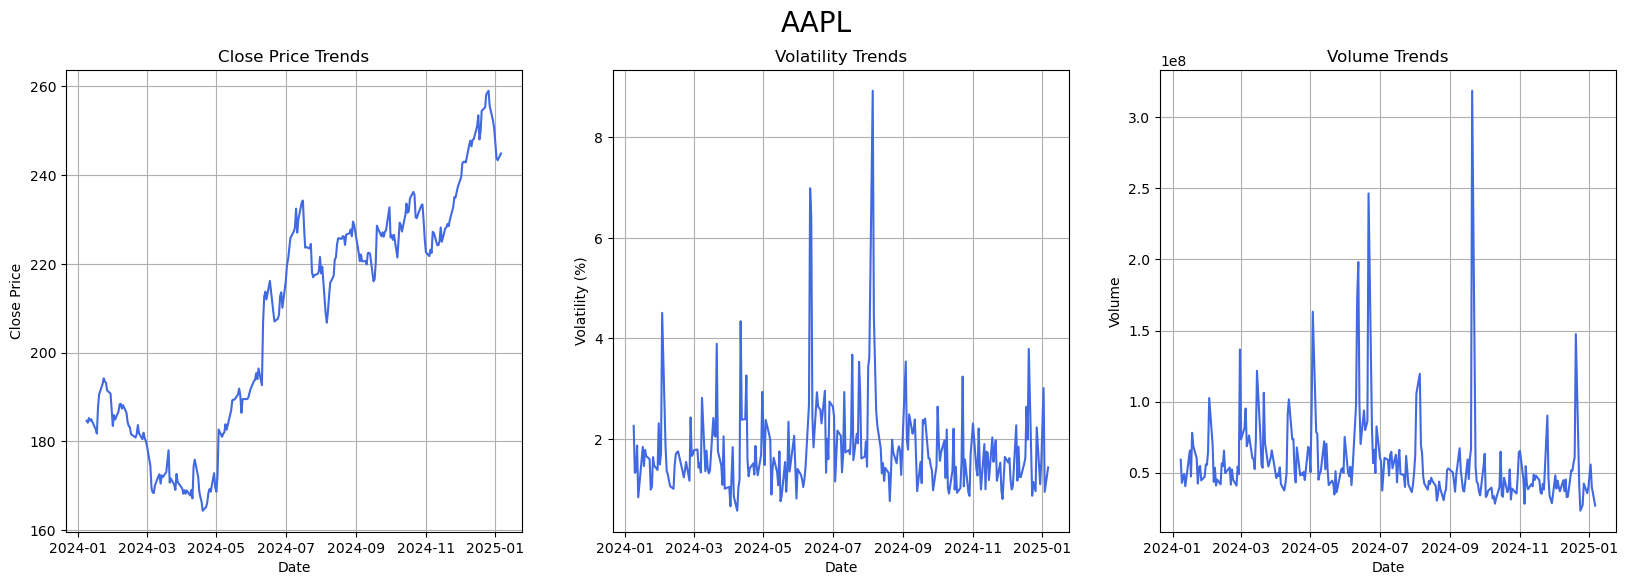

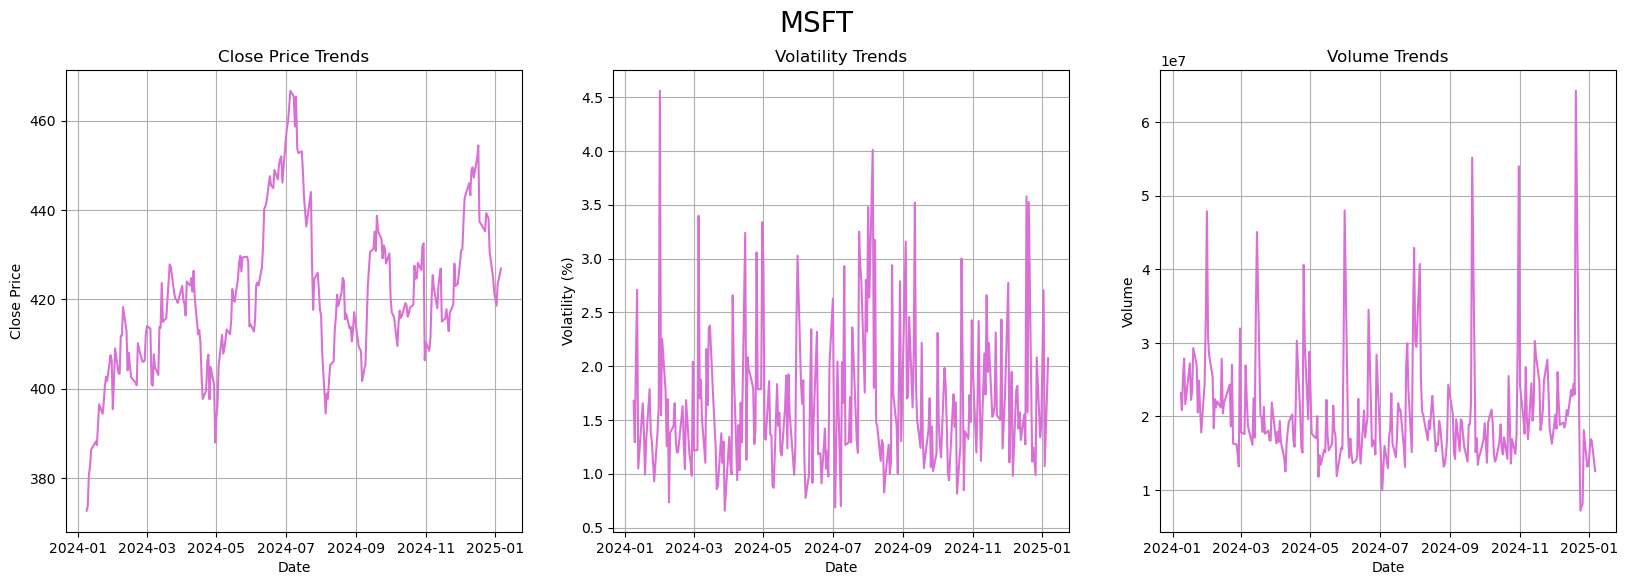

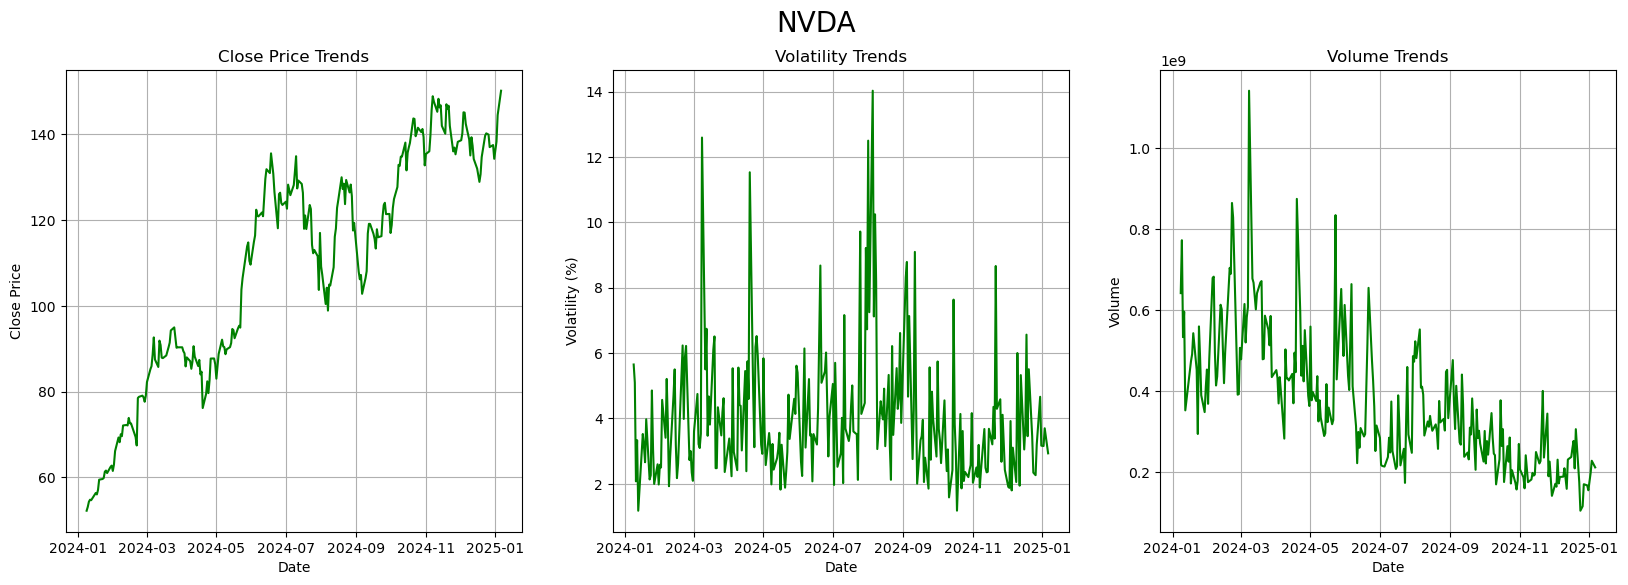

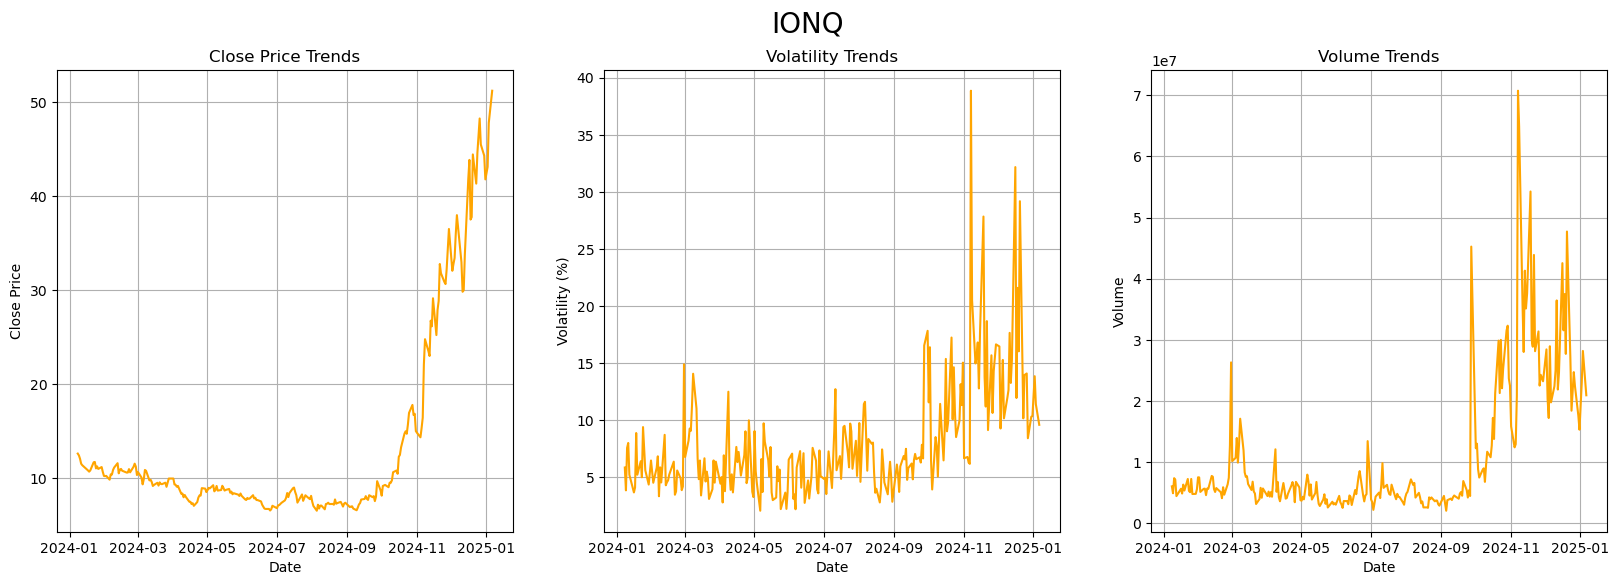

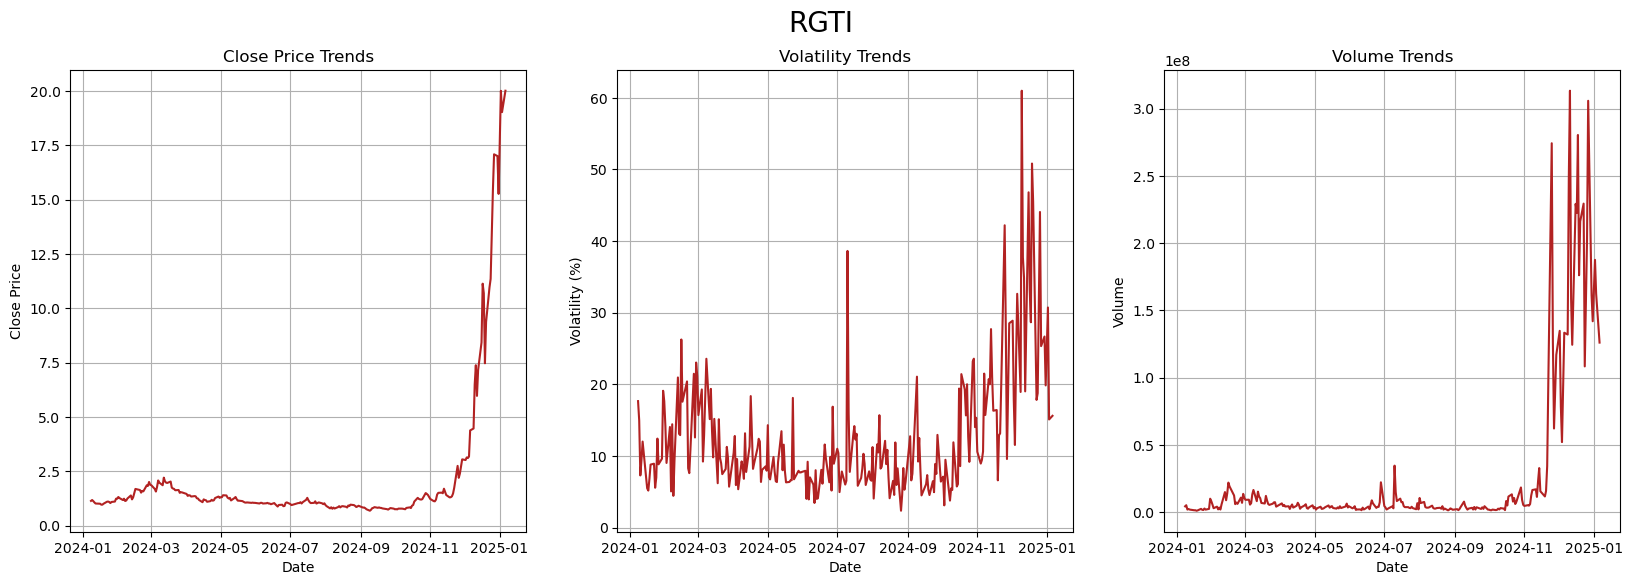

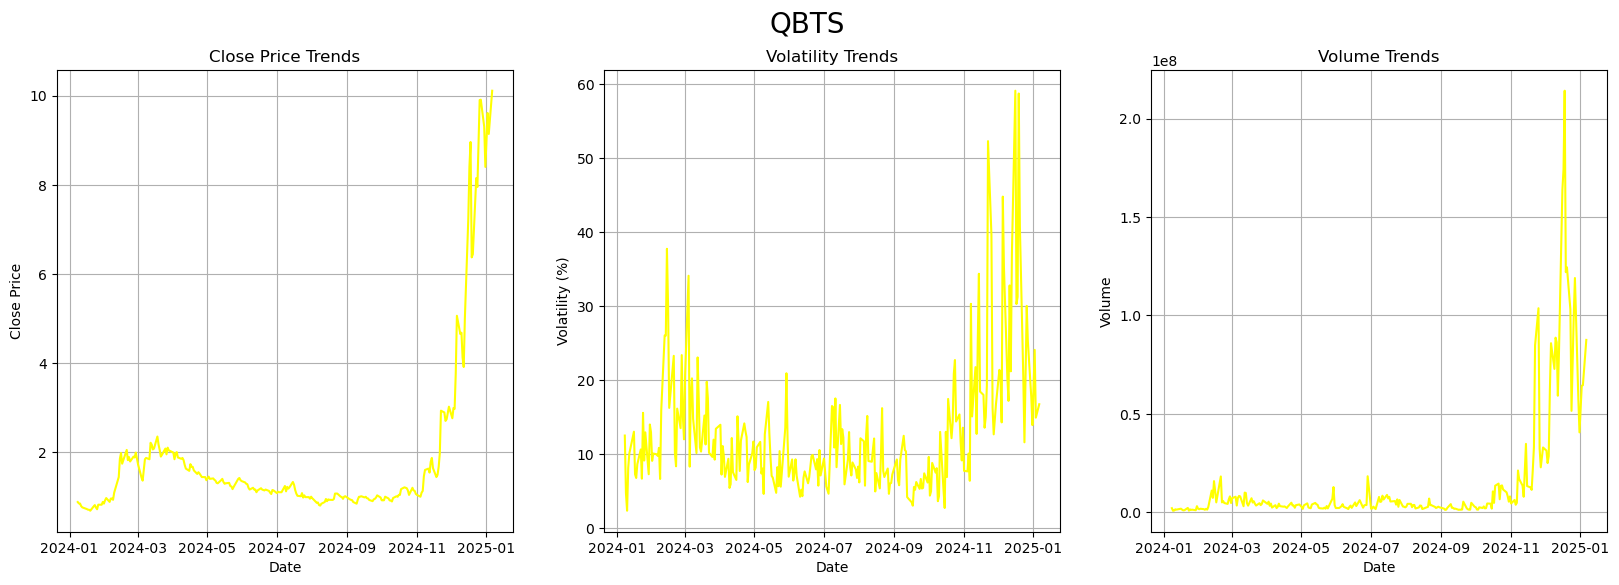

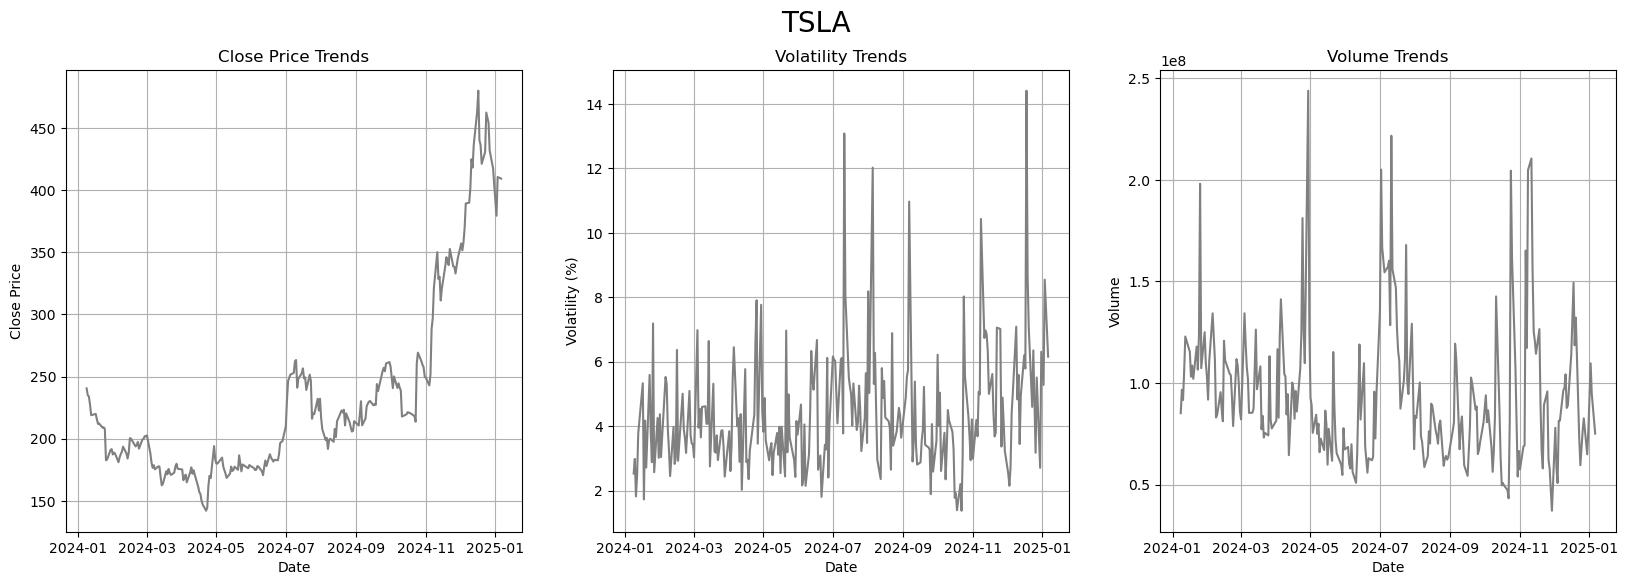

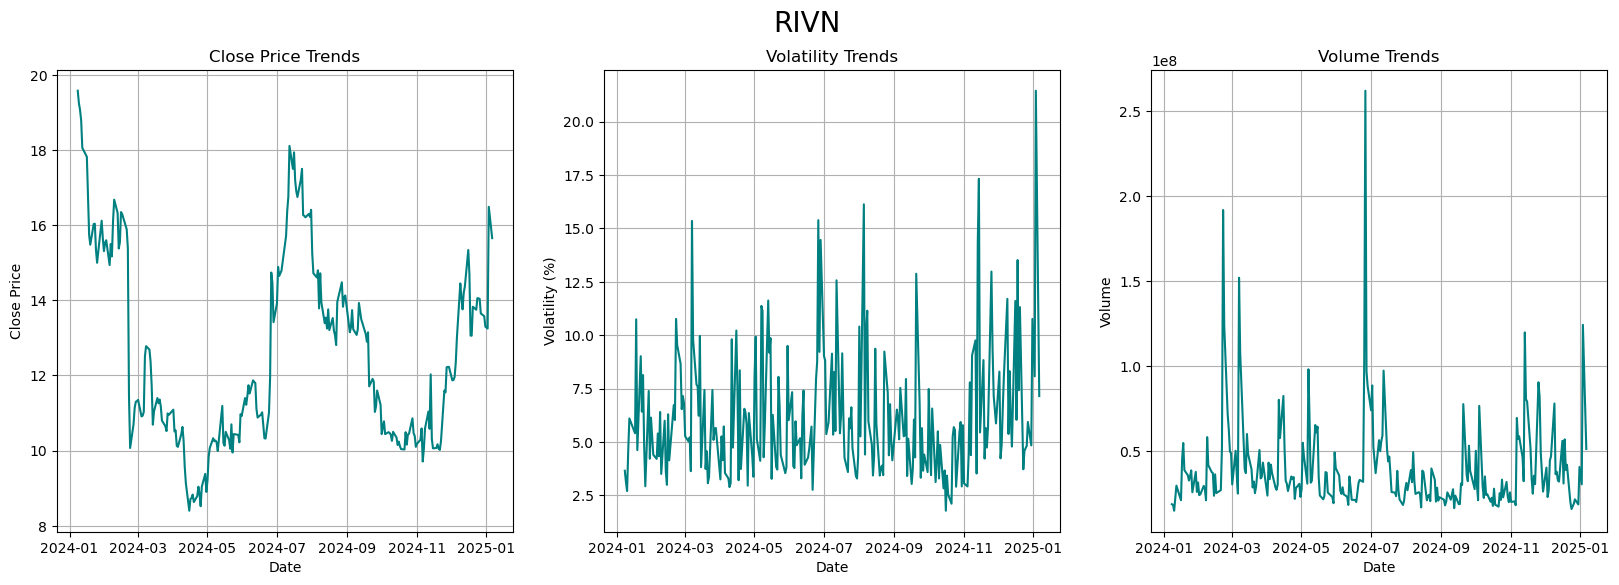

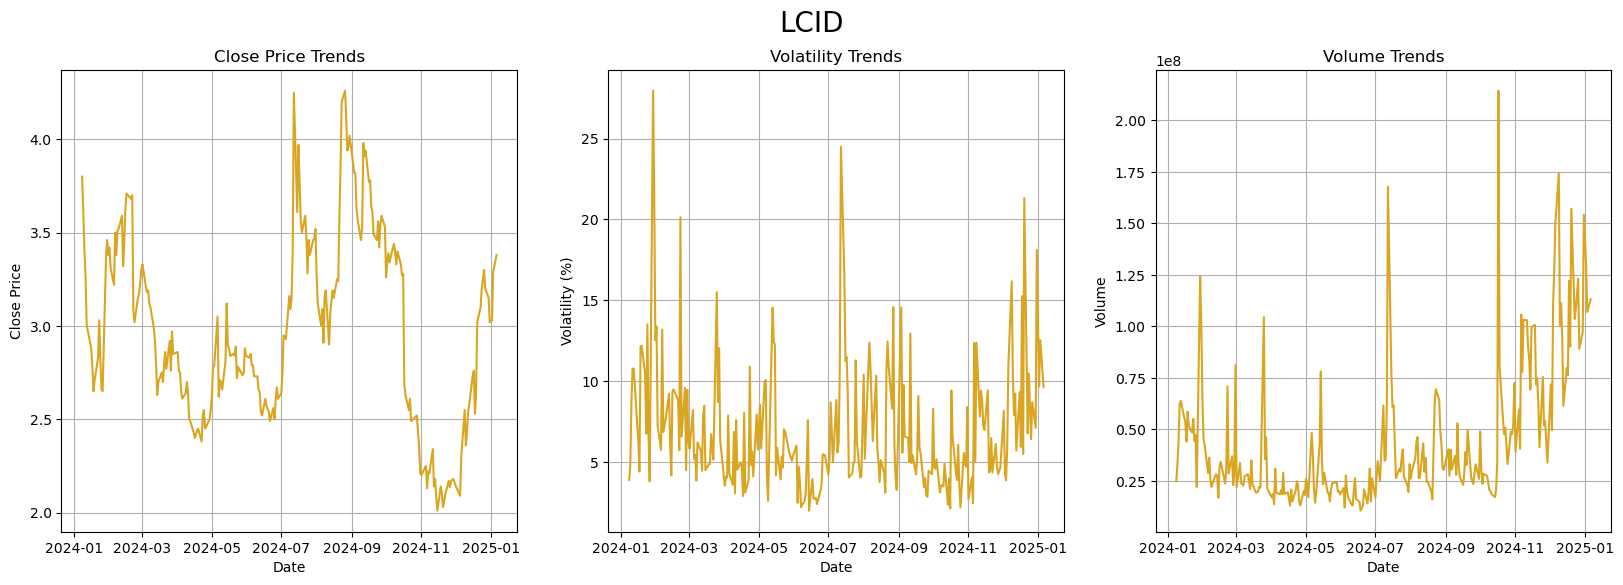

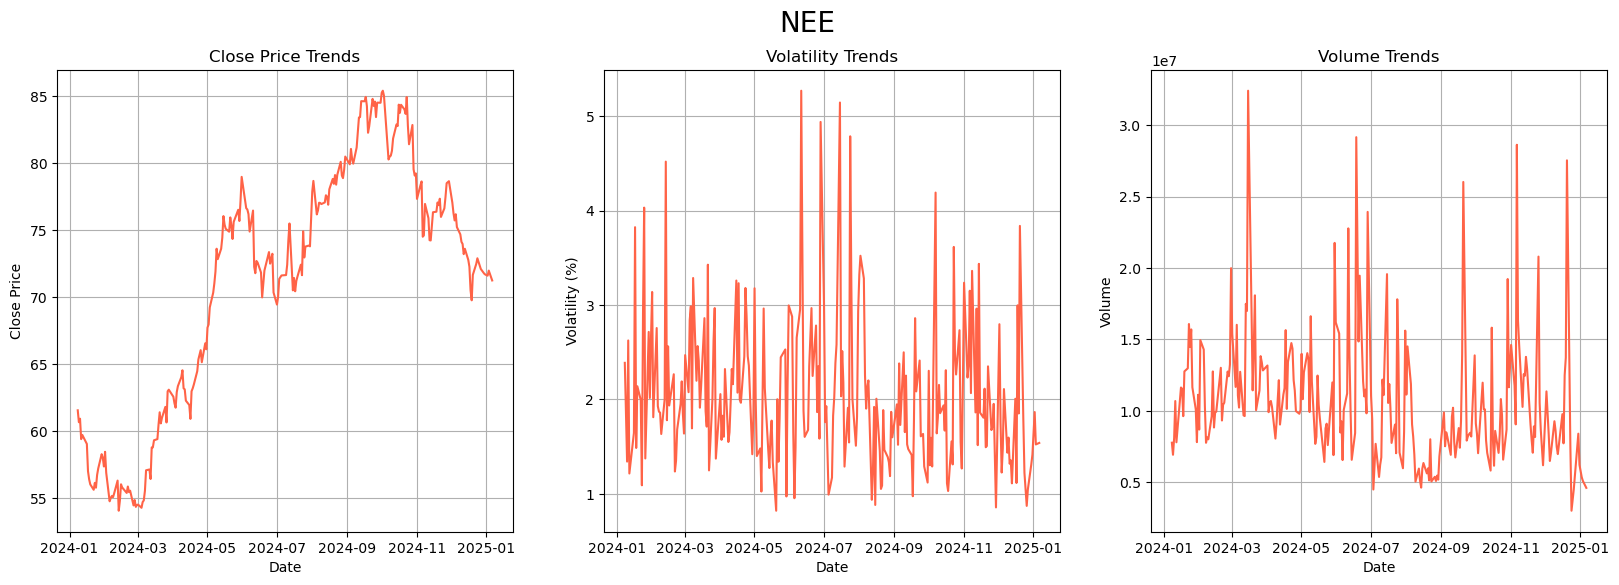

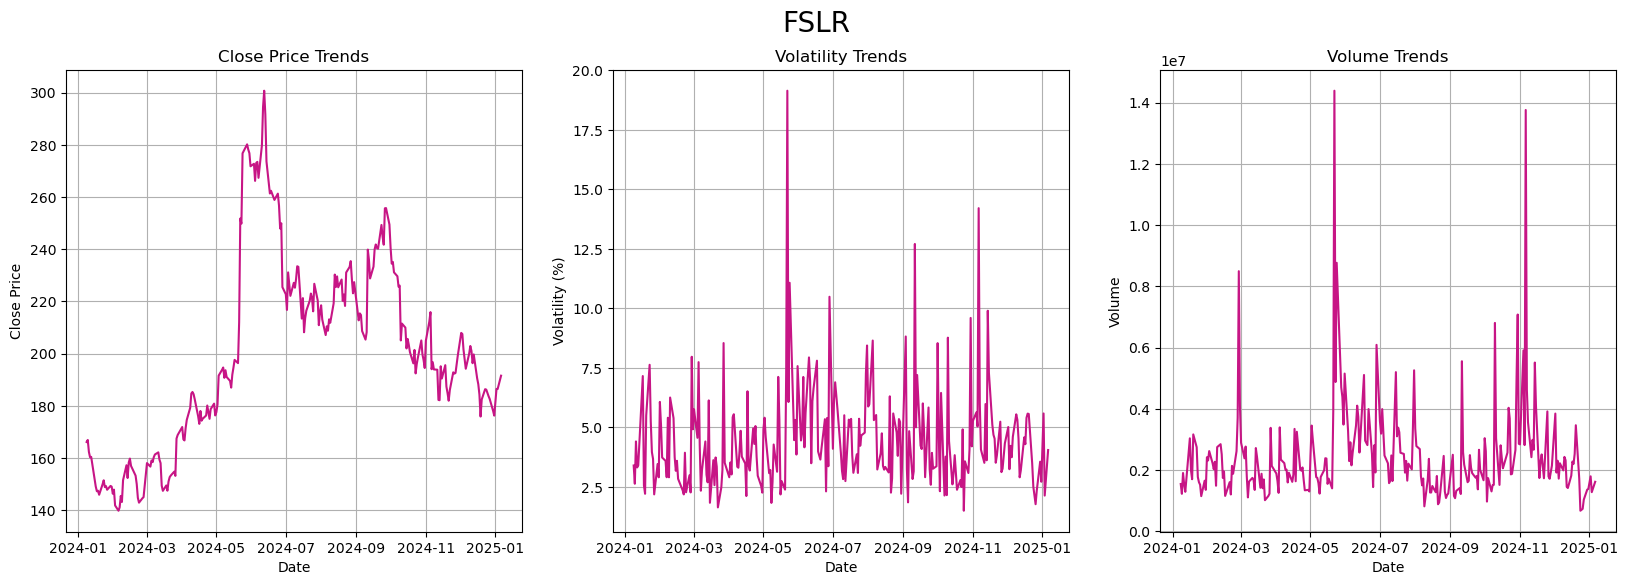

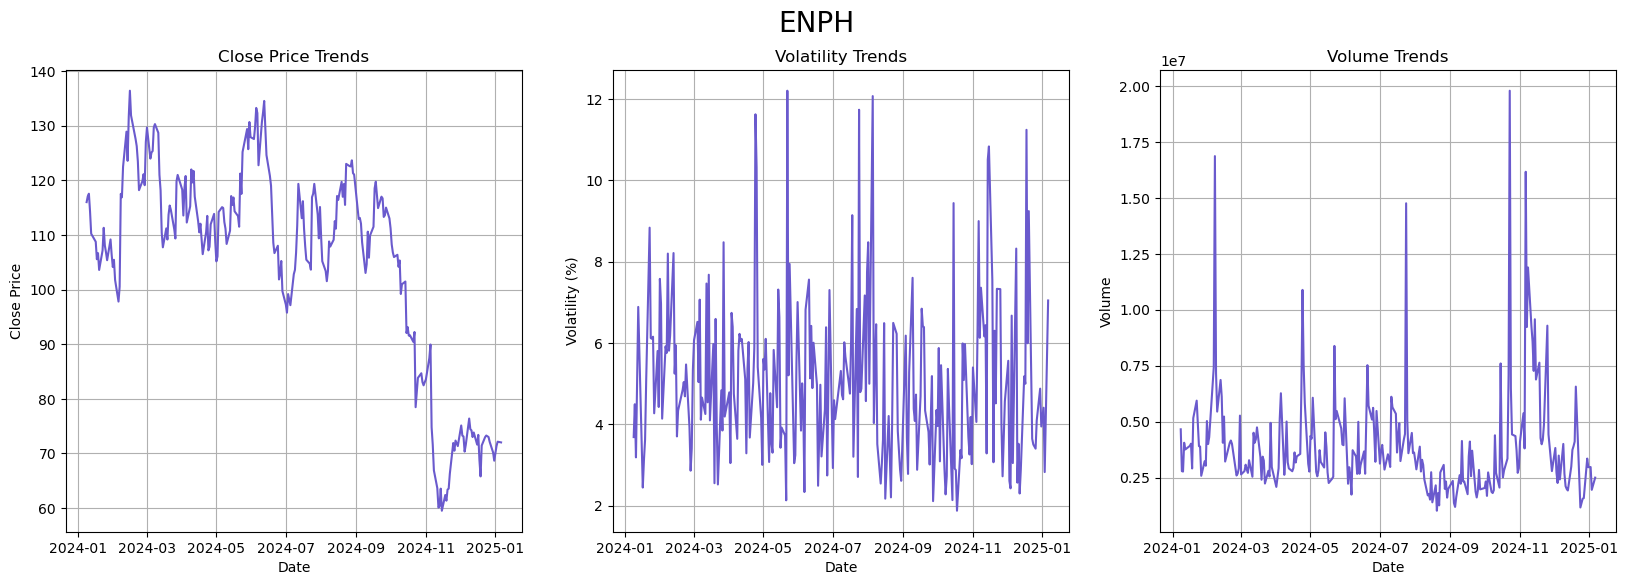

In [ ]:
# looping through the 1y dataset looking for unique values in industries
for company in industry_dataframes['1y']['Company'].unique():
    # copying the data filtering on the company value
    company_df = industry_dataframes['1y'][industry_dataframes['1y']['Company'] == company].copy()
    
    # fetching the colour to be used for the line plot from the dictionary holding the pairings
    color=colours_comp.get(company)

    # setting the size of the figure to be used for the subplot creation
    plt.figure(figsize=(20,6))

    # setting up the first subplot
    plt.subplot(1,3,1)
    # 1. Close Price Trends
    plt.plot(company_df['Close'], color=color)
    plt.title('Close Price Trends')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True)


    plt.subplot(1,3,2)
    # 2. Volatility Analysis
    company_df['Volatility'] = (((company_df['High'] - company_df['Low']) / company_df['Low']) * 100)
    plt.plot(company_df['Volatility'], color=color)
    plt.title('Volatility Trends')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.grid(True)

    plt.subplot(1,3,3)
    # 3. Trading Volume Patterns
    plt.plot(company_df['Volume'], color=color)
    plt.title('Volume Trends')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.grid(True)

    plt.suptitle(company, fontsize = 20)
    plt.show()


## Industry-Wide performance

As a first step in looking at the performance of the industries the data will be resampled.  
For each industry the data is resampled to show the mean amount of the close prices for the companies at a 1 day interval.   

### All industries over past 1 year

In [14]:
# creating an empty DataFrame to store the combined data for the mean close prices for all timeframes
industry_mean_close_combined = pd.DataFrame()

# iterating through time periods and industries to calculate mean Close prices
for time_period in ['1y', '5y', '10y']:
    for industry in industries.keys():
        # skipping 5y and 10y for industries without enough data (Quatum computing and Electronic Vehicles)
        if time_period in ['5y', '10y'] and industry not in ['Renewable Energy', 'Technology']:
            continue 

        # filtering the dataframe for the specific industry and time period
        industry_df = industry_dataframes[time_period][industry_dataframes[time_period]['Industry'] == industry]

        # resampling the data by day and calculatinig the mean close price
        daily_mean = industry_df['Close'].resample('D').mean()

        temp_df = pd.DataFrame(daily_mean)  # converting the data to a dataframe
        # assigning the values for the industry and timeframe column
        # these columns will be important for enabling the data in the dataframe to be selected for a specific time period or industry
        temp_df['Industry'] = industry
        temp_df['Timeframe'] = time_period

        # appending the data to the combined dataframe
        industry_mean_close_combined = pd.concat([industry_mean_close_combined, temp_df])

# quick check of the combined dataframe
print(industry_mean_close_combined)

                 Close          Industry Timeframe
Date                                              
2024-01-08  203.182301        Technology        1y
2024-01-09  203.703242        Technology        1y
2024-01-10  206.768762        Technology        1y
2024-01-11  207.343665        Technology        1y
2024-01-12  208.688843        Technology        1y
...                ...               ...       ...
2025-01-02  109.813334  Renewable Energy       10y
2025-01-03  110.189997  Renewable Energy       10y
2025-01-04         NaN  Renewable Energy       10y
2025-01-05         NaN  Renewable Energy       10y
2025-01-06  111.604136  Renewable Energy       10y

[12424 rows x 3 columns]


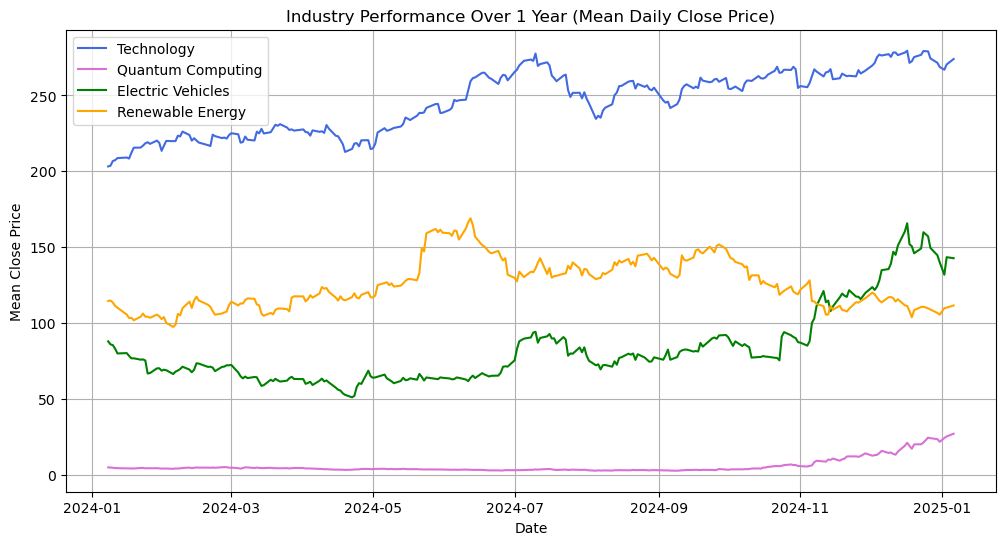

In [15]:
# filtering the combinded data in the dataframe to just select the data for the 1-year timeframe
filtered_df = industry_mean_close_combined[industry_mean_close_combined['Timeframe'] == '1y']

# creating a copy for plotting, so the original data remains unchanged
plot_df = filtered_df.copy()

# applying interpolation to handle missing values in the 'Close' column
plot_df['Close'] = plot_df['Close'].interpolate(method='linear')  # Interpolating missing values based on the prior and following values entered

# creating the plot
plt.figure(figsize=(12, 6))

# looping through each industry in the 1-year data by each unique value in the 'Industry' column
for industry in plot_df['Industry'].unique():
    # filtering data for the specified industry
    industry_data = plot_df[plot_df['Industry'] == industry]
    
    # getting the colour from the colours dictionary specified for that industry
    color = colours.get(industry)

    # ploting the data using the datetime index
    plt.plot(industry_data.index, industry_data['Close'], label=industry, color=color)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Mean Close Price')
plt.title('Industry Performance Over 1 Year (Mean Daily Close Price)')
plt.legend()
plt.grid(True)
plt.show()


### Technology & Renewable energy


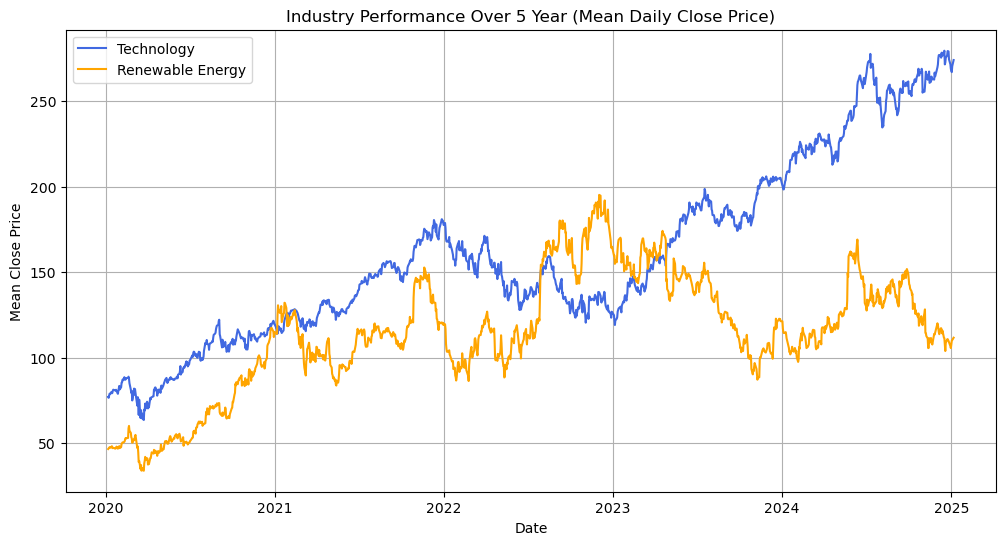

In [16]:
# filtering the combinded data in the dataframe to just select the data for the 5-year timeframe
filtered_df = industry_mean_close_combined[industry_mean_close_combined['Timeframe'] == '5y']

# creating a copy for plotting, so the original data remains unchanged
plot_df = filtered_df.copy()

# applying interpolation to handle missing values in the 'Close' column
plot_df['Close'] = plot_df['Close'].interpolate(method='linear')

# creating the plot
plt.figure(figsize=(12, 6))

# looping through each industry in the 5-year data by each unique value in the 'Industry' column
for industry in plot_df['Industry'].unique():
    # filtering data for the specified industry
    industry_data = plot_df[plot_df['Industry'] == industry]
    
    # getting the colour from the colours dictionary specified for that industry
    color = colours.get(industry)
    
    # ploting the data using the datetime index
    plt.plot(industry_data.index, industry_data['Close'], label=industry, color=color)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Mean Close Price')
plt.title('Industry Performance Over 5 Year (Mean Daily Close Price)')
plt.legend()
plt.grid(True)
plt.show()



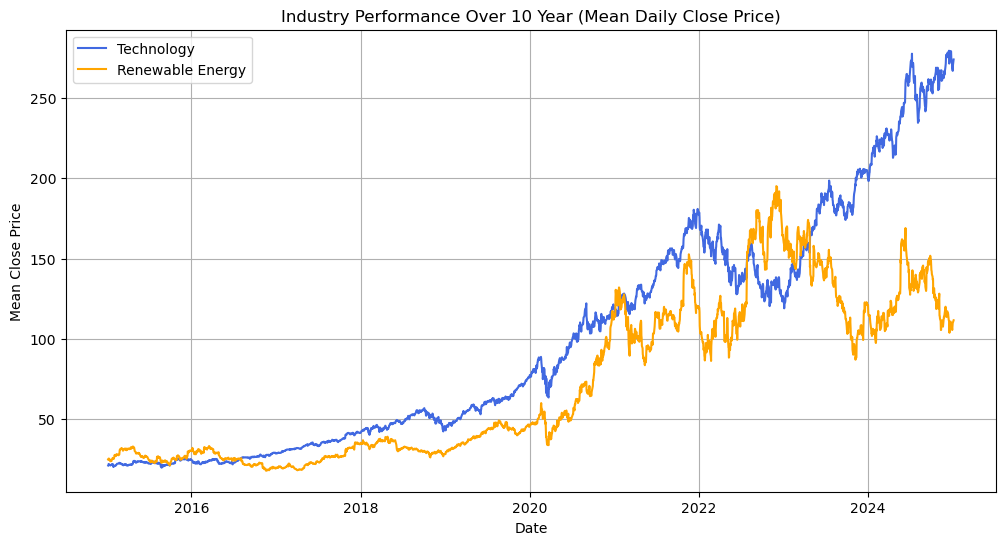

In [17]:
# filtering the combinded data in the dataframe to just select the data for the 10-year timeframe
filtered_df = industry_mean_close_combined[industry_mean_close_combined['Timeframe'] == '10y']

# creating a copy for plotting, so the original data remains unchanged
plot_df = filtered_df.copy()

# applying interpolation to handle missing values in the 'Close' column
plot_df['Close'] = plot_df['Close'].interpolate(method='linear')

# creating the plot
plt.figure(figsize=(12, 6))

# looping through each industry in the 10-year data by each unique value in the 'Industry' column
for industry in plot_df['Industry'].unique():
    # filtering data for the specified industry
    industry_data = plot_df[plot_df['Industry'] == industry]
    
    # getting the colour from the colours dictionary specified for that industry
    color = colours.get(industry)
    
    # ploting the data using the datetime index
    plt.plot(industry_data.index, industry_data['Close'], label=industry, color=color)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Mean Close Price')
plt.title('Industry Performance Over 10 Year (Mean Daily Close Price)')
plt.legend()
plt.grid(True)
plt.show()


### Volatility


In [18]:
# calculating the volatility and storing in the dataframes for the different time periods
for time_period in ['5y', '1y', '10y']: 

    industry_dataframes[time_period]['Volatility'] = (
        (industry_dataframes[time_period]['High'] - industry_dataframes[time_period]['Low']) / 
        industry_dataframes[time_period]['Low']
) * 100
    
# print(industry_dataframes['10y']) for testing to see if volatility is added

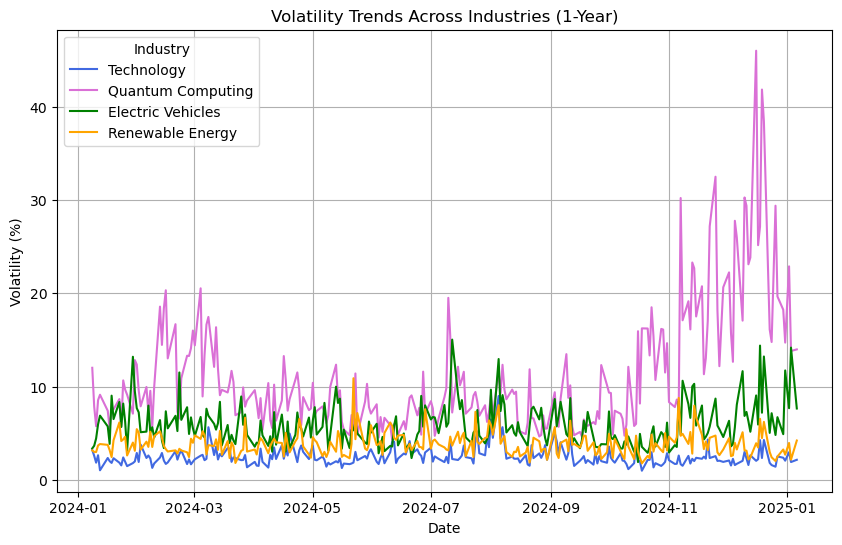

In [19]:
plt.figure(figsize=(10, 6))

# looping through the 1y dataset looking for unique values in industries
for industry in industry_dataframes['1y']['Industry'].unique():
    # filtering the data for the current industry
    industry_data = industry_dataframes['1y'][industry_dataframes['1y']['Industry'] == industry]

    # grouping the data by date and calculating the mean volatility using the agg function
    grouped_data = industry_data.groupby(industry_data.index).agg({
        'Volatility': 'mean'  # Aggregate volatility
    })

    # getting the colour from the colours dictionary specified for that industry
    color = colours.get(industry)

    # plotting the aggregated volatility for the industry
    plt.plot(grouped_data.index, grouped_data['Volatility'], label=industry, color=color)

# adding labels and title
plt.title('Volatility Trends Across Industries (1-Year)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend(title='Industry')
plt.grid(True)

plt.show()


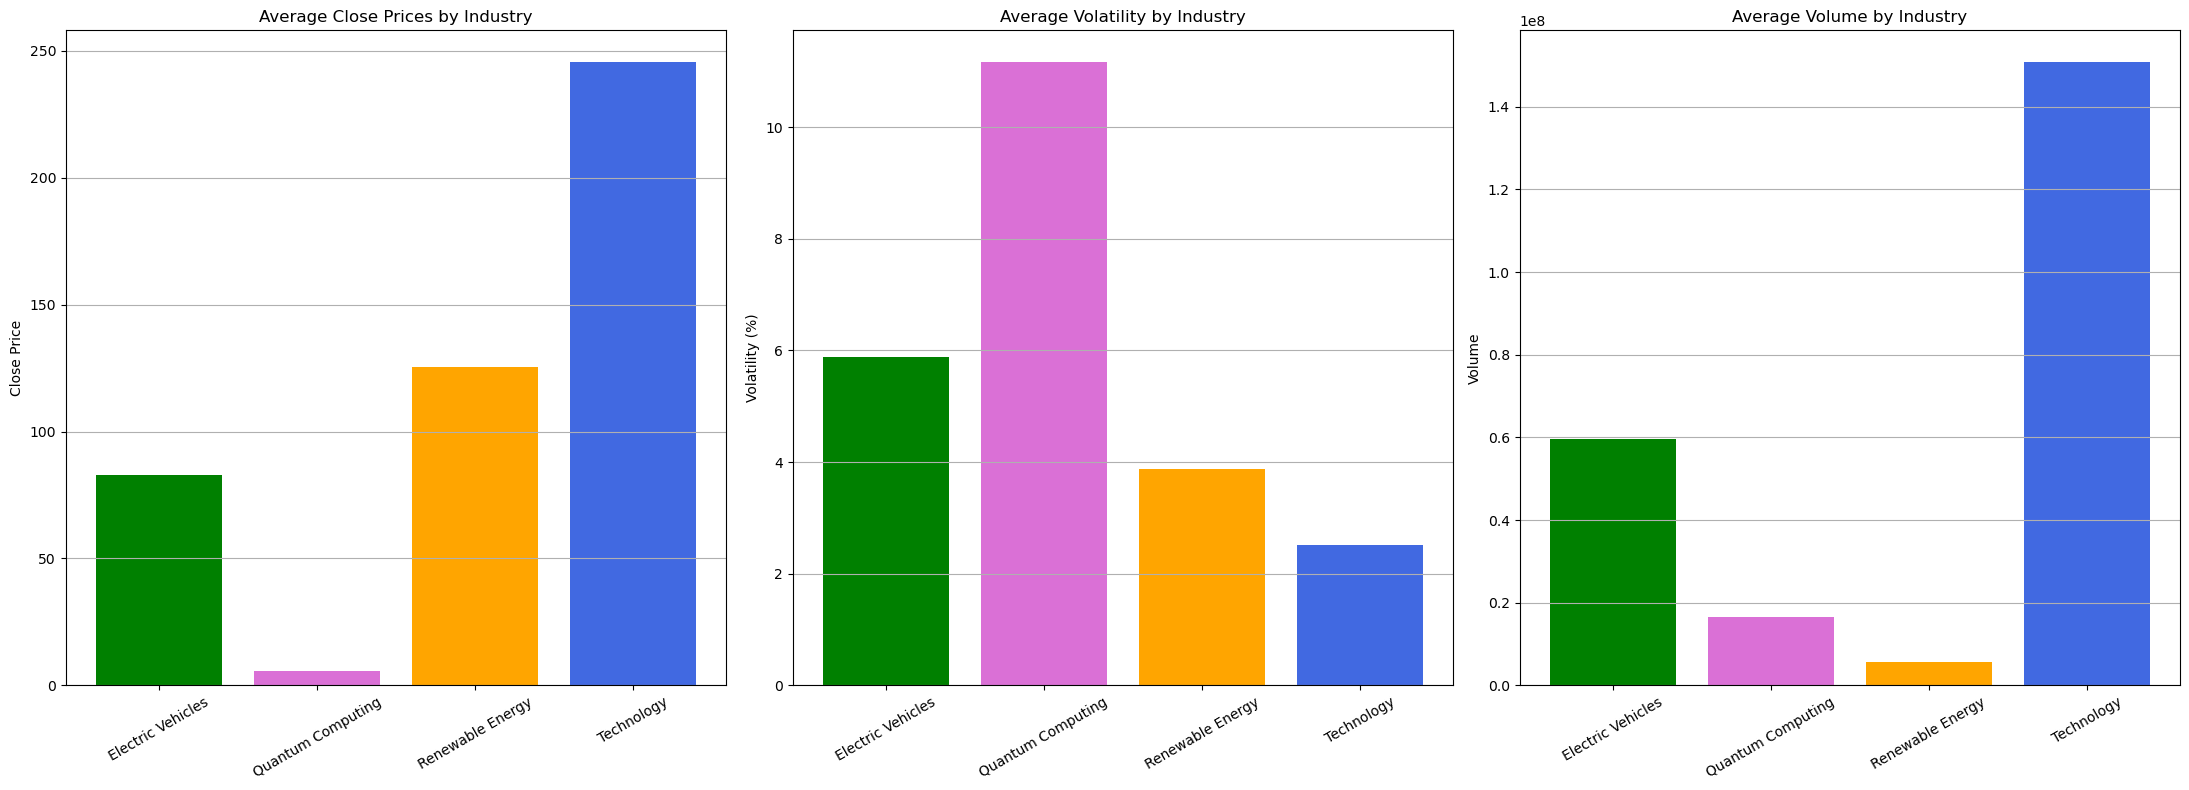

In [20]:

# getting the average per industry for the close, volatility and volume data for the 1y df
industry_avg = industry_dataframes['1y'].groupby('Industry')[['Close', 'Volatility', 'Volume']].mean()

# creating a suplot to show the values per industry
plt.figure(figsize=(22,8)) # setting the size of the overall image to increase readability

plt.subplot(1, 3, 1) # first looking at the close values across the industries 
plt.bar(industry_avg.index, industry_avg['Close'], # using the index for industry_avg as the bases for the x axis and the labels
        color=[colours.get(ind) for ind in industry_avg.index] ) # using the industry names in the index for the grouped values to find the correct colour and assign it 
plt.title('Average Close Prices by Industry')
plt.xticks(rotation=30) # rotating the x labels so they are not overlapping
plt.ylabel('Close Price')
plt.grid(visible=True, which='major', axis='y') # adding lines on the y axis to help readability

# next the process is repeated for the volatility and volume data per indusrty and plotted

plt.subplot(1, 3, 2)
plt.bar(industry_avg.index, industry_avg['Volatility'], 
        color=[colours.get(ind) for ind in industry_avg.index])
plt.title('Average Volatility by Industry')
plt.xticks(rotation=30)
plt.ylabel('Volatility (%)')
plt.grid(visible=True, which='major', axis='y')

plt.subplot(1, 3, 3)
plt.bar(industry_avg.index, industry_avg['Volume'], 
        color=[colours.get(ind) for ind in industry_avg.index])
plt.title('Average Volume by Industry')
plt.xticks(rotation=30)
plt.ylabel('Volume')
plt.grid(visible=True, which='major', axis='y')

plt.tight_layout()
plt.show()


### Correlation

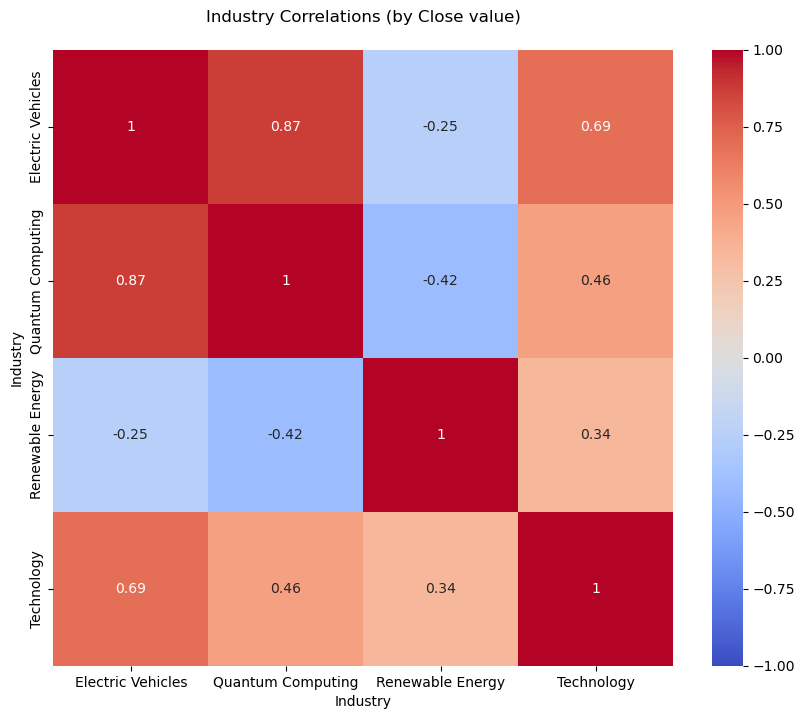

In [21]:
# restructuring the data to get the close prices based on the 'Close' prices for the industries
industry_corr = industry_dataframes['1y'].pivot_table(index=industry_dataframes['1y'].index, columns='Industry', values='Close')
#print(industry_corr) for testing results for .pivot_table

# calculating the correlation between industries
industry_corr = industry_corr.corr()

# plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(industry_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Industry Correlations (by Close value)', pad=20)
plt.grid(False)
plt.show()


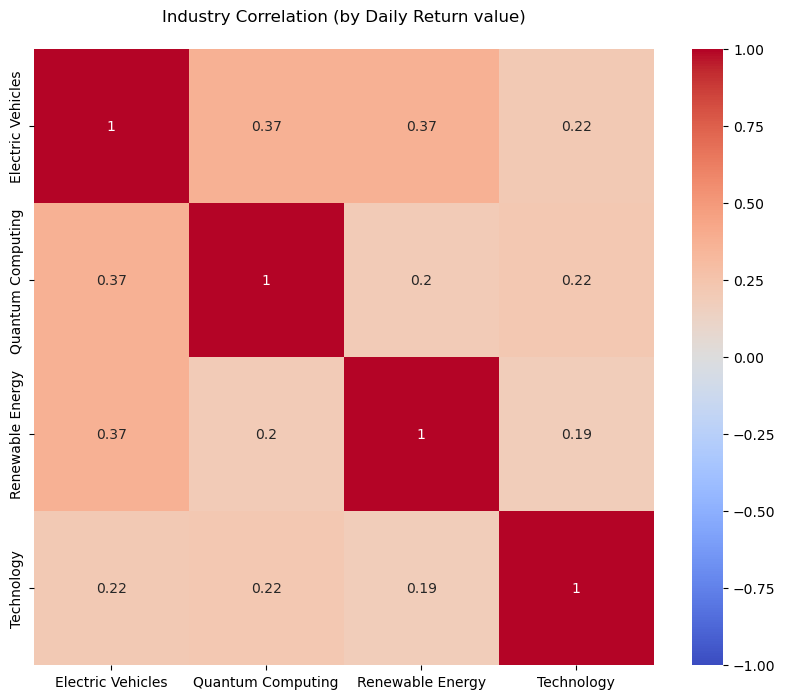

In [22]:
# restructuring the data to get the close prices based on the 'Close' prices for each company 
company_returns = industry_dataframes['1y'].pivot_table(index=industry_dataframes['1y'].index, columns='Company', values='Close')

# calculating the percentage change for the companies close prices row by row individually using the pivot table 
company_returns = company_returns.pct_change()

# converting the pivot table structure to have the pivot headers feed in as values in the rows with new overarching headers created
company_returns_long = company_returns.stack().rename('Daily_Returns').reset_index() # converts the multiIndex of Date and Company back to columns

# used for checking outputs
# print(company_returns)
# print(company_returns_long) 

# merging the data for the percentage change values to the 1y df based on 'Date' and 'Company' from company_returns_long 
industry_dataframes['1y'] = industry_dataframes['1y'].reset_index()  # temporarily resetting the index in the orginal dataframe to a 'Date' column to use as a bases to merge the data
industry_dataframes['1y'] = industry_dataframes['1y'].merge(
    company_returns_long,
    on=['Date', 'Company'],  # matching the rows based explicitly on values for company and date
    how='left' # keeping all data from the left df (industry_dataframes['1y']) in case of missing values from the company_returns_long dataset
)

# resetting the index back to a DatetimeIndex using the 'Date' column after merging
industry_dataframes['1y'].set_index('Date', inplace=True)

# creating mapping from companies to industries using the industries dictionary defined in the beginning of the notebook
company_to_industry = {}
for industry, companies in industries.items(): # cycling through the industries and companies in the dictionar
    for company in companies: 
        company_to_industry[company] = industry # looping through the companies individually and setting the pairing in the company_to_industry dictionary of teh company and correspending industry details

# tranposing the company_returns dataset and using the company_to_industry dictionary to gourp the companies by industry
grouped_returns = company_returns.T.groupby(company_to_industry)
industry_mean_returns = grouped_returns.mean() # calculating the mean returns per industry using the grouped data
industry_returns = industry_mean_returns.T # transposing back to the original format with the dates as rows

# calculating the correlations between industries
industry_corr = industry_returns.corr()

# plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(industry_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Industry Correlation (by Daily Return value)', pad=20)
plt.xlabel(None)
plt.ylabel(None)
plt.grid(False)
plt.show()

#print(industry_returns)

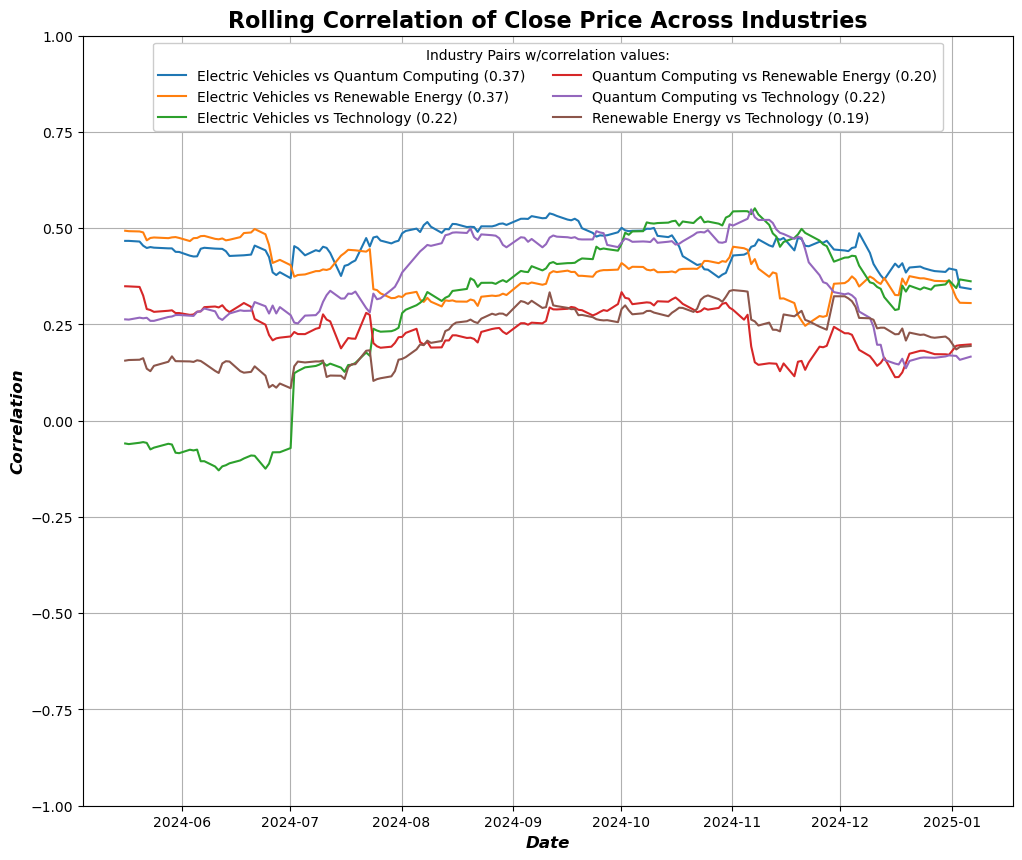

In [23]:
# rolling Correlation Analysis for all industry pairs
plt.figure(figsize=(12, 10))
for i, industry1 in enumerate(industry_returns.columns): # parent loop cycling through the column names for industry_returns to use as the first value for the correlation
    for j, industry2 in enumerate(industry_returns.columns): # nested loop cycling through the column names for industry_returns to use as the second value for the correlation
        if i < j:  # if statement to avoid duplicate pairs and self-pairs based comparison of the values of the i and j counters 
            rolling_corr = industry_returns[industry1].rolling(window=90).corr( # checking the correlation per industry pair with  90 day rolling window
                industry_returns[industry2])
            plt.plot(rolling_corr, label=f'{industry1} vs {industry2} ({industry_returns[industry1].corr(industry_returns[industry2]):.2f})') # plotting the results and showing the correlation coefficient value in the legend

# customizing the visuals of the plot
plt.title('Rolling Correlation of Close Price Across Industries', fontweight='bold', fontsize=16)
plt.xlabel('Date', fontsize=12, fontweight='bold', fontstyle='italic')
plt.ylabel('Correlation', fontsize=12, fontweight='bold', fontstyle='italic')
plt.ylim(-1, 1) # setting y min and max values to match the range of the possible answers for the correlation coefficient
plt.grid(True)
plt.legend(loc='upper center', ncols = 2, fontsize=10, framealpha=1.0, title='Industry Pairs w/correlation values:') # customising the legend to make it more readible
plt.show()

### Distribution Analysis

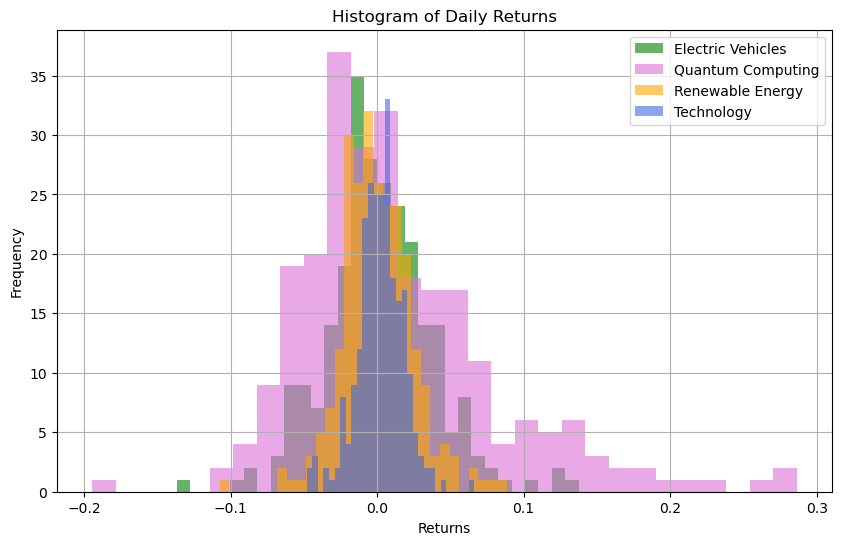

In [24]:
# plotting a histogram to show the distribution of the daily returns per industry 
# getting the colour from the colours dictionary specified for that industry
color = colours.get(industry)

# creating plot 
plt.figure(figsize=(10, 6))
for i, industry in enumerate(industry_returns.columns): # looping through the industry_returns header names to dynamically use them as the value for the histogram
    color = colours.get(industry) # getting the specified colour for the industry from the dictionary containing the colours
    industry_returns[industry].hist(bins=30, alpha=0.6, label=industry, color=color) # plotting the results per industry for the histograms

# customising the plot title and labels
plt.title('Histogram of Daily Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend() # adding legend
plt.grid(True) # adding grid to increase readablity
plt.show()


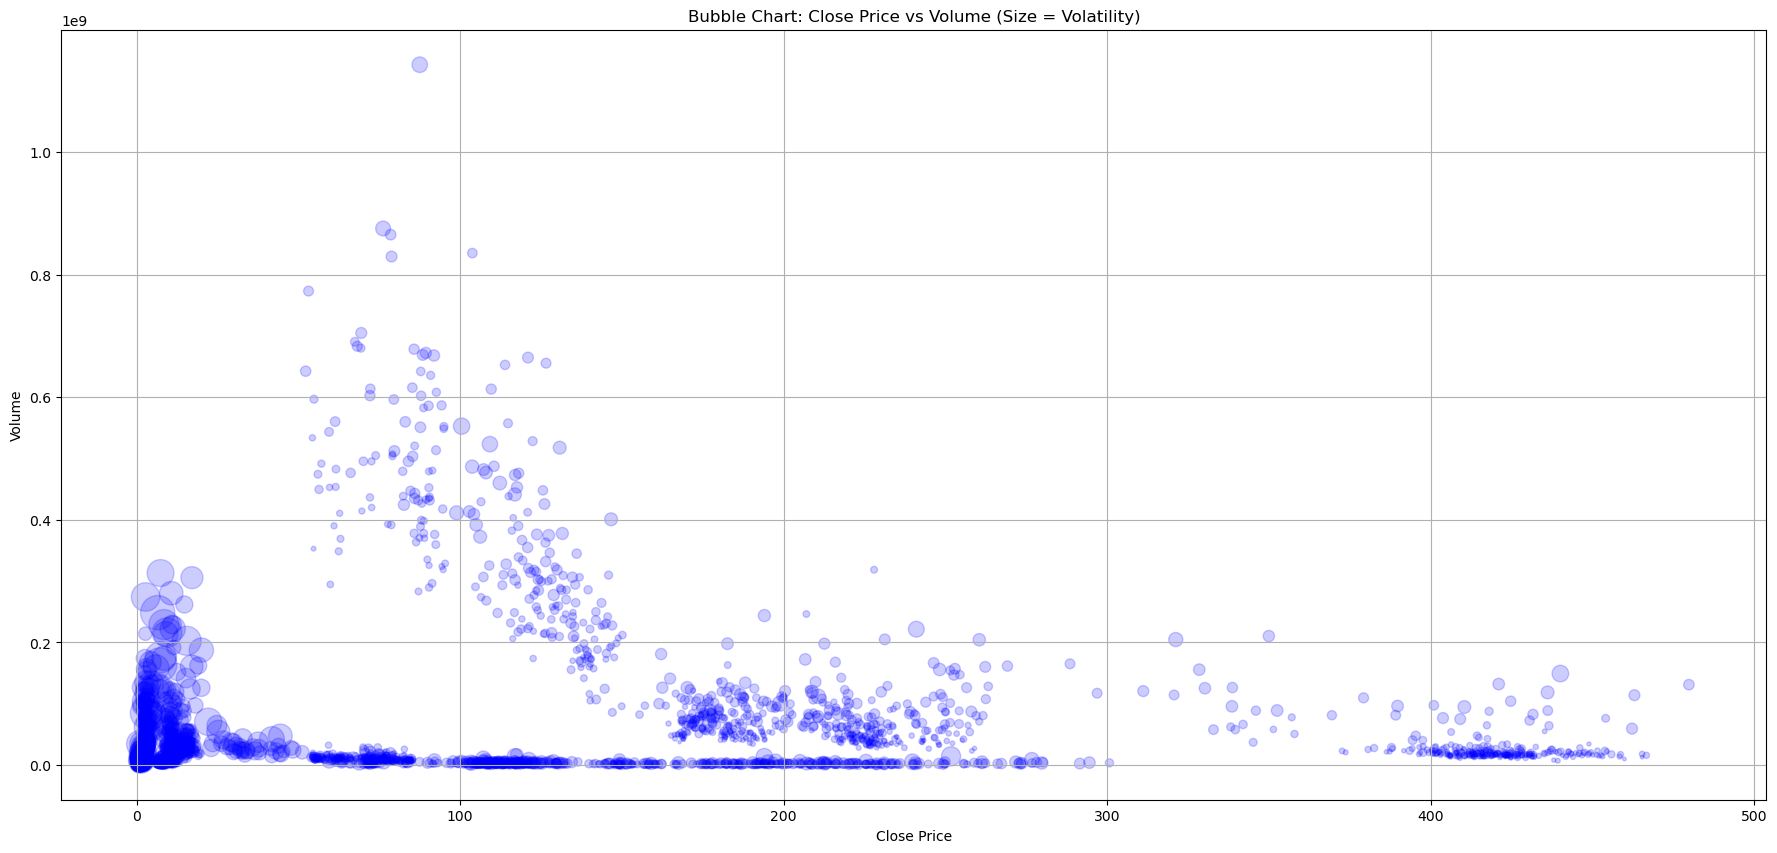

In [ ]:
# creating a scatter chart with a 3rd dimension of increasing the size of the marker depending on the volatility of the stock
plt.figure(figsize=(22, 10))


plt.scatter(industry_dataframes['1y']['Close'], # setting the x axis 
            industry_dataframes['1y']['Volume'], # setting the y axis 
            s=industry_dataframes['1y']['Volatility']*10, alpha=0.2, c='blue') # setting the size, transparency and colour of the markers

# customising the plot
plt.title('Bubble Chart: Close Price vs Volume (Size = Volatility)')
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.grid(True)
plt.show()


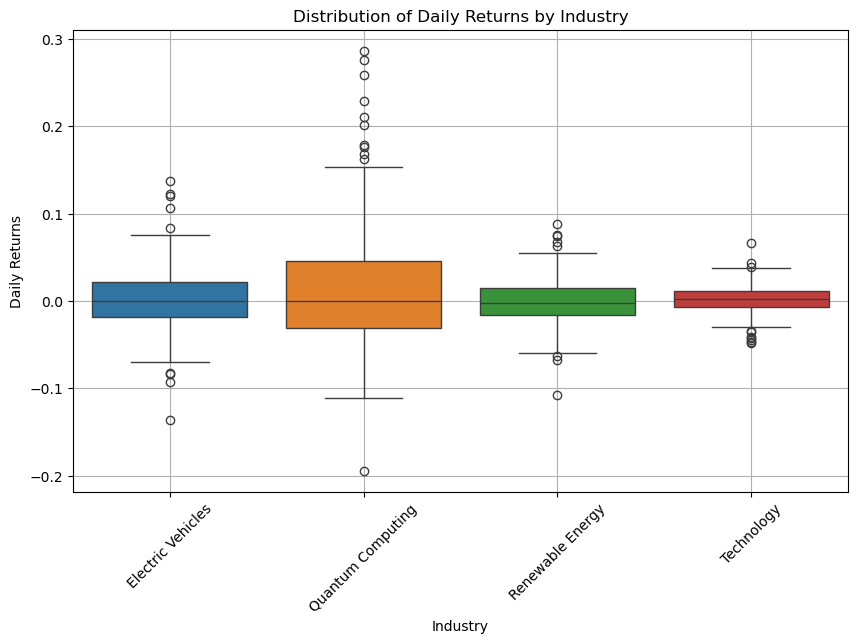

In [26]:
# creating a boxplot to show the distribution of the daily returns by industry 

plt.figure(figsize=(10, 6))
sns.boxplot(data=industry_returns)

# customizing  the plot
plt.title('Distribution of Daily Returns by Industry')
plt.xlabel('Industry')
plt.ylabel('Daily Returns')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


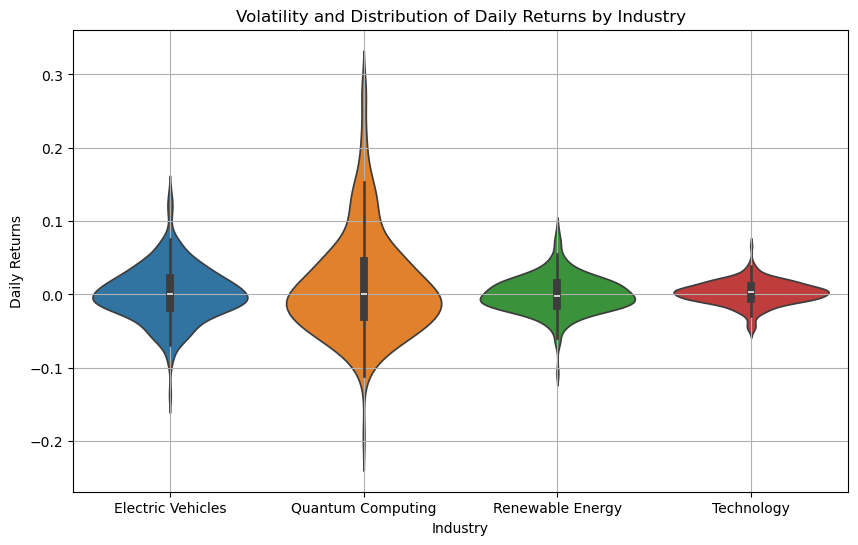

In [27]:

plt.figure(figsize=(10, 6))
sns.violinplot(data=industry_returns)
plt.title('Volatility and Distribution of Daily Returns by Industry')
plt.xlabel('Industry')
plt.ylabel('Daily Returns')
plt.grid(True)
plt.show()


In [28]:
# creating an empty list to store summary statistics for each industry
industry_summary = []

# fetching the data for each industry by looping through the key value pairs returned from the .items() method
for industry, companies in industries.items():
    data = yf.Tickers(' '.join(companies))  # .Tickers() function is used to fetch the data for all of the companies in the list within the industry for that iteration of the for loop
    # creating lists to store the  market capitalisations, P/E ratios and dividend yields per company
    market_caps = []
    pe_ratios = []
    dividend_yields = []

    # getting the data for each company within the industry specified for the parent for loop
    for company in companies:
        info = data.tickers[company].info  # retrieveing detailed information about the company

        # Adding the market cap, P/E ratio and dividend yield for the current company to the lists defined above
        # getting the market cap and trailing P/E ratio, defaulting to 0 if data is missing
        market_caps.append(info.get('marketCap', 0))  
        pe_ratios.append(info.get('trailingPE', 0))
        #calculating the dividend yield as a percentage
        dividend_yields.append(info.get('dividendYield', 0) * 100 if info.get('dividendYield') else 0)

    # calculating the averages for the market cap, P/E ratio and dividend yield for the industry using the values added to the 3 lists for each company
    # first the 3 values are added together then the length of list is used to divide the sum giving the average for each industry
    avg_market_cap = sum(market_caps) / len(market_caps)
    avg_pe_ratio = sum(pe_ratios) / len(pe_ratios)
    avg_dividend_yield = sum(dividend_yields) / len(dividend_yields)

    # adding the results for the industry to the summary list
    industry_summary.append({
        'Industry': industry,  # industry name
        'Avg Market Cap ($B)': round(avg_market_cap / 1e9, 2),  # average market cap in billions
        'Avg P/E Ratio': round(avg_pe_ratio, 2),  # average price-to-earnings ratio
        'Avg Dividend Yield (%)': round(avg_dividend_yield, 2)  # Average dividend yield percentage
    })

# creating a DataFrame to store and display results 
summary_df = pd.DataFrame(industry_summary)  # converting summary list into a DataFrame
print(summary_df)  # displaying the summary table


            Industry  Avg Market Cap ($B)  Avg P/E Ratio  \
0         Technology              3516.58          44.94   
1  Quantum Computing                 6.46           0.00   
2  Electric Vehicles               446.26          37.34   
3   Renewable Energy                58.93          64.75   

   Avg Dividend Yield (%)  
0                    0.41  
1                    0.00  
2                    0.00  
3                    0.95  
